In [1]:
import os
import numpy as np
import cv2
import torch
from datetime import datetime
from time import sleep
from PIL import Image
from torchvision import transforms
from torch import nn, optim
from torch.optim.lr_scheduler import *
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader
from matplotlib import pyplot as plt
from shutil import copyfile, rmtree

/home/agent006/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if os.path.exists("data"): # automatically recognize
    rootPath = "data" + os.sep
elif os.path.exists("dataset"):
    rootPath = "dataset" + os.sep
else:
    rootPath = input("Relative Folder: ").replace("\"", "").replace("\'", "").replace(os.sep, "") + os.sep

useNet = 50
enhance_tmp = None#"_new"
enhance_step = 8
enhance_clear = True
pauseTime = 10 # to have a rest, e.g. 10s, 30s, 60s, 0 for no rests
modelpth = "model.pth"

In [3]:
# ["ResNet18", "ResNet34", "ResNet50", "ResNet101", "ResNet152"]
netSeries = (18, 34, 50, 101, 152)
netDict = {18:24, 34:14, 50:18, 101:8, 152:12}
if useNet in netSeries:
    exec("from torchvision.models.resnet import resnet{0}\nresnet = resnet{0}(pretrained = True)".format(useNet))
else:
    raise ModuleNotFoundError

if not rootPath.endswith(os.sep) and not rootPath.endswith("/"):
    rootPath += os.sep

pauseTime = abs(int(pauseTime))
enhance_seek = 3 << (enhance_step << 1)
print(enhance_seek)

196608


In [4]:
if enhance_tmp is not None:
    assert(enhance_step >= 0)
    print("Files", "->", (1 << enhance_step, 1 << enhance_step, 3), end = "\n\n")
    enhance_tmp = rootPath[:-1] + enhance_tmp
    
    if enhance_clear and os.path.isdir(enhance_tmp):
        rmtree(enhance_tmp)
    
    for directory in os.listdir(rootPath):
        currentWork = os.path.join(rootPath, directory)
        if os.path.isdir(currentWork):
            targetWork = os.path.join(enhance_tmp, directory)
            if not os.path.isdir(targetWork):
                os.makedirs(targetWork)
            if len(os.listdir(targetWork)) > 0:
                continue
            print("\n{0} -> {1}\n".format(currentWork, targetWork))
            total_count = 0 # counter
            for file in os.listdir(currentWork):
                currentFile = os.path.join(currentWork, file)
                if os.path.isfile(currentFile):
                    if cv2.imread(currentFile) is not None: # if is an available figure
                        copyfile(currentFile, os.path.join(targetWork, str(total_count) + os.path.splitext(currentFile)[1].lower()))
                        print("{0} -> {1}{2}".format(file, total_count, os.path.splitext(currentFile)[1].lower()))
                        total_count += 1 # Remember to add the counter
                    else:
                        with open(currentFile, "rb") as f:
                            imdata = list(f.read())
                        seek = enhance_seek
                        in_count = 1
                        while seek < len(imdata):
                            np_array = np.array(imdata[seek - enhance_seek:seek]).reshape(1 << enhance_step, 1 << enhance_step, 3)
                            #print(np_array)
                            assert(cv2.imwrite(os.path.join(targetWork, str(total_count) + ".png"), np_array))
                            assert(cv2.imread(os.path.join(targetWork, str(total_count) + ".png")) is not None)
                            print("{0} [{1}:{2}] [{3}:{4}] -> {5}.png".format(file, in_count - 1, in_count, seek - enhance_seek, seek, total_count))
                            total_count += 1
                            in_count += 1
                            seek += enhance_seek
    
    rootPath = enhance_tmp + os.sep
    print("Change rootPath to " + rootPath)

In [5]:
classes = []
for i in os.listdir(rootPath):
    if os.path.isdir(rootPath + i):
        classes.append(i)
    assert(i.lower() != ".ipynb_checkpoints")
classes = tuple(classes)
print(classes)
class_count = len(classes)
assert(class_count > 0)

('1', '0')


In [6]:
if useNet in netSeries[:2]:
    PIL_transform = transforms.RandomApply([transforms.RandomHorizontalFlip(p = 1), transforms.RandomVerticalFlip(p = 1),\
        transforms.RandomRotation(45)], p = 0.5)
elif useNet in netSeries[2:]:
    PIL_transform = transforms.RandomApply([transforms.RandomHorizontalFlip(p = 1), transforms.RandomVerticalFlip(p = 1),\
        transforms.RandomRotation(45)], p = 0.4)
else:
    raise ModuleNotFoundError

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # resize to 256x256
    PIL_transform,
    transforms.RandomCrop((225, 225)),  # randomly cut to 224x224
    #transforms.RandomHorizontalFlip(),  # flip horizontally
    transforms.ToTensor(),
    transforms.Normalize((0.0268, 0.2314, 0.0270), (0.0046, 0.0785, 0.0467))  # Normalization, the value is given by Imagenet
])
 
# Processing of data set verification set
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.0268, 0.2314, 0.0270), (0.0046, 0.0785, 0.0467)),
])
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU is better than CPU
cell_dataset = datasets.ImageFolder(root = rootPath, transform = transform_train)

#define dataloader
dataset_loader = DataLoader(cell_dataset, batch_size = 16, shuffle = True, num_workers = 8)

split1 = int(0.1 * len(cell_dataset))
split2 = int(0.9 * len(cell_dataset))
index_list = list(range(len(cell_dataset)))
np.random.shuffle(index_list) 
test_idx = index_list[:split1] + index_list[split2:]
train_idx = index_list[split1:split2]

## create training and validation sampler objects
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(test_idx)
#trainset = cell_dataset[split1:split2]

## create iterator objects for train and valid datasets
trainloader = DataLoader(cell_dataset, batch_size = 16, sampler = tr_sampler, num_workers = 8)
validloader = DataLoader(cell_dataset, batch_size = 16, sampler = val_sampler, num_workers = 8)

In [7]:
print(device)

cuda


In [8]:
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total
 
def train(epoch):
    print("\nEpoch: {0}".format(epoch))
    #scheduler.step()
    model.train()
    train_acc = 0.0
    for batch_idx, (img, label) in enumerate(trainloader):
        image = img.to(device)
        label = label.to(device)
        optimizer2.zero_grad()
        out = model(image)
        #print('out:{}'.format(out))
        #print(out.shape)
        #print('label:{}'.format(label))
        loss = criterion(out, label)
        loss.backward()
        optimizer2.step()
        train_acc = get_acc(out, label)
        print("Epoch: {0} [{1}|{2}]  loss: {3}  acc: {4}".format(epoch, batch_idx, len(trainloader), loss.mean(), train_acc))
    scheduler.step()
 
 
def val(epoch):
    print("\nValidation Epoch: {0}".format(epoch))
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (img, label) in enumerate(validloader):
            image = img.to(device)
            label = label.to(device)
            out = model(image)
            _, predicted = torch.max(out.data, 1)
            total += image.size(0)
            correct += predicted.data.eq(label.data).cpu().sum()
    print("Acc: {0}".format((1.0 * correct.numpy()) / total))
    return (1.0 * correct.numpy()) / total

 
class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 5, stride = 2, padding = 2, bias = False)
        self.resnet_layer = nn.Sequential(*list(model.children())[1:-1])# Remove the last layer of the model
        if useNet == 18 or useNet == 34:
            self.Linear_layer = nn.Linear(512, 8) # Add a full connection layer with modified parameters
        elif useNet == 50 or useNet == 101 or useNet == 152:
            self.Linear_layer = nn.Linear(2048, 32) # Add a full connection layer with modified parameters
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        return x

In [9]:
# train
model = Net(resnet)
model = model.to(device)
optimizer1 = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.8, weight_decay = 3e-3) # Set training details
optimizer2 = optim.Adam(model.parameters(), lr = 1e-4, betas = (0.9, 0.999), eps = 1e-8, weight_decay = 5e-4, amsgrad = True)
scheduler = StepLR(optimizer2, step_size = 4, gamma = 0.3)
criterion = nn.CrossEntropyLoss()

epochs = netDict[useNet]

results_x = [epoch for epoch in range(epochs)]
startTime = datetime.now()
results_y = []
for epoch in range(epochs):
    train(epoch)
    results_y.append(val(epoch))
    if epoch != epochs - 1:
        sleep(pauseTime)
endTime = datetime.now()


Epoch: 0
Epoch: 0 [0|365]  loss: 3.121882438659668  acc: 0.5
Epoch: 0 [1|365]  loss: 3.064404249191284  acc: 0.1875
Epoch: 0 [2|365]  loss: 2.7567574977874756  acc: 0.5625
Epoch: 0 [3|365]  loss: 2.7266039848327637  acc: 0.3125
Epoch: 0 [4|365]  loss: 2.3497507572174072  acc: 0.75
Epoch: 0 [5|365]  loss: 2.3873865604400635  acc: 0.375
Epoch: 0 [6|365]  loss: 2.063062906265259  acc: 0.5625
Epoch: 0 [7|365]  loss: 2.050626516342163  acc: 0.25
Epoch: 0 [8|365]  loss: 1.9061062335968018  acc: 0.5
Epoch: 0 [9|365]  loss: 1.6438721418380737  acc: 0.625
Epoch: 0 [10|365]  loss: 1.7605830430984497  acc: 0.375
Epoch: 0 [11|365]  loss: 1.4915119409561157  acc: 0.4375
Epoch: 0 [12|365]  loss: 1.40635347366333  acc: 0.5
Epoch: 0 [13|365]  loss: 1.330297589302063  acc: 0.5625
Epoch: 0 [14|365]  loss: 1.1050984859466553  acc: 0.6875
Epoch: 0 [15|365]  loss: 1.1256818771362305  acc: 0.625
Epoch: 0 [16|365]  loss: 0.925966739654541  acc: 0.6875
Epoch: 0 [17|365]  loss: 0.9509677886962891  acc: 0.6875

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0.6856554564172959, 0.7110501029512697, 0.7467398764584763, 0.7405628002745367, 0.8002745367192862, 0.7940974605353466, 0.7886067261496225, 0.7899794097460535, 0.8332189430336308, 0.8236101578586136, 0.8270418668496912, 0.8339052848318462, 0.8249828414550446, 0.8277282086479066, 0.8380233356211393, 0.8277282086479066, 0.8339052848318462, 0.8352779684282773]


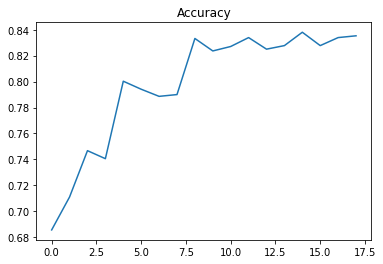

max_acc: 83.80233356211393%, epoch: 14, time: 437.075723s


In [10]:
print(results_x)
print(results_y)
plt.title("Accuracy")
plt.plot(results_x, results_y)
plt.show()
print("max_acc: {0}%, epoch: {1}, time: {2:.6f}s".format(max(results_y) * 100, results_y.index(max(results_y)),\
    ((endTime - startTime).total_seconds() - pauseTime * epochs) * (results_y.index(max(results_y)) + 1) / (epochs - 1)))
torch.save(model, modelpth) # save model

In [11]:
model = torch.load(modelpth) # load model

In [12]:
if torch.cuda.is_available():
    model = torch.load(modelpth)
else:
    model = torch.load(modelpth, map_location = 'cpu')
model.cpu()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (resnet_layer): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [13]:
# verification
class_correct = list(0. for i in range(class_count))
class_total = list(0. for i in range(class_count))
with torch.no_grad():
    for data in validloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(class_count):
            try:
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            except IndexError:
                pass
        #print(class_correct, class_total)

for i in range(class_count):
    if class_total[i] == 0:
        if sum(class_total) == 0:
            print("This model is not available on the questions you are trying to solve. ")
        else:
            print("Average maximum accuracy: {0}%".format(100 * sum(class_correct) / sum(class_total)))
        break
else: # naturally break
    for i in range(class_count):
        print("Number of correct:", class_correct[i], "Number of total:", class_total[i])
        print("Accuracy of {0}: {1}%".format(classes[i], 100 * class_correct[i] / class_total[i]))

Number of correct: 73.0 Number of total: 89.0
Accuracy of 1: 82.02247191011236%
Number of correct: 80.0 Number of total: 93.0
Accuracy of 0: 86.02150537634408%
